In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

In [44]:
class LassoMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(LassoMLP, self).__init__()
        
        # Define beta as a learnable parameter for each input feature
        self.beta = nn.Parameter(torch.ones(input_dim))  # Initialize beta to 1 for each input feature
        
        # Define the layers: three layers with two hidden layers and one output layer
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        # Activation functions
        self.tanh = nn.Tanh()  # tanh for hidden layers
        
    def forward(self, x):
        # Scale input features by beta
        x = x * self.beta  # Element-wise multiplication with beta
        x = self.layer1(x)       # First hidden layer with tanh activation
        x = self.layer2(x)       # Second hidden layer with tanh activation
        x = self.output_layer(x)  # Output layer with linear activation
        return x

In [ ]:
# Step 1: Define function to train or retrain the neural network
def train_network(model, X_train, y_train, lambda_, num_epochs=100, learning_rate=0.01):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()  # Mean Squared Error loss function

    for epoch in range(num_epochs):  # Use the num_epochs argument
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(X_train)
        loss = criterion(predictions, y_train)
        
        # Add L1 regularization for all weights in the model
        lasso_penalty = 0
        for param in model.beta:
            lasso_penalty += torch.sum(torch.abs(param))
        loss += lambda_ * lasso_penalty
        

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        # Optional: Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model

In [30]:
# Step 3: Use K-fold cross-validation to find the optimal lambda
def select_lambda(X, y, lambdas, k_folds=5):
    kf = KFold(n_splits=k_folds)
    best_lambda = None
    best_score = float('inf')

    for lambda_ in lambdas:
        print(f"Testing lambda = {lambda_}")
        scores = []

        for train_idx, val_idx in kf.split(X):
            model = LassoMLP(input_dim=X.shape[1], hidden_dim=64, output_dim=X.shape[1])
            # model = LassoMLP(input_dim=X.shape[1], hidden_dim=64, output_dim=1)
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # print(f"Training with {len(X_train)} samples, validating with {len(X_val)} samples")

            # Train the model and calculate the validation loss
            trained_model = train_network(model, X_train, y_train, lambda_)
            model.eval()
            with torch.no_grad():
                predictions = trained_model(X_val)
                val_loss = mean_squared_error(y_val.numpy(), predictions.numpy())
                scores.append(val_loss)

        # Take the average score over all folds
        avg_score = np.mean(scores)
        if avg_score < best_score:
            best_score = avg_score
            best_lambda = lambda_

    return best_lambda

In [31]:
# Step 4-5: Iteratively prune features with zero β
def lasso_mlp_algorithm(X, y, output_dim, hidden_dim=64, num_epochs=100, learning_rate=0.001, lambdas=[0.1, 1, 10]):
    input_dim = X.shape[1]
    output_dim = input_dim
    termination = False
    # lambdas = np.arange(0, 1.01, 0.01)
    # lambdas = np.append(lambdas, 100)

    c = 0
    while not termination:
        print(f"Iteration {c + 1}:")
        # Initialize and train the network
        model = LassoMLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
        
        # Select the optimal lambda
        best_lambda = select_lambda(X, y, lambdas)
        print(f"Optimal lambda: {best_lambda}")

        # Train the model with the optimal lambda
        trained_model = train_network(model, X, y, best_lambda, num_epochs=num_epochs, learning_rate=learning_rate)

        # Get the estimated β values
        beta_estimates = model.beta.detach().cpu().numpy()
        
        # Step 5: Check for termination (if no non-zero β values)
        non_zero_beta = beta_estimates != 0
        if np.sum(non_zero_beta) == input_dim:  # If all β are non-zero, terminate
            termination = True
        else:
            # Remove features with β = 0 and create a new dataset
            X = X[:, non_zero_beta]
            input_dim = X.shape[1]  # Update input dimension
            c += 1

    return trained_model, beta_estimates

In [32]:
df = pd.read_csv('https://raw.githubusercontent.com/tiagoft/NLP/main/wiki_movie_plots_drama_comedy.csv')

x, y = df["Plot"][0:1000], df["Genre"][0:1000]

# df = pd.read_csv('pumadyn-32nm\puma32H.data', sep=',', header=None)

display(df.head())

# x, y = df.iloc[:, :-1], df.iloc[:, -1]

,Plot,Genre
0,The film is about a family who move to the sub...,comedy
1,Before heading out to a baseball game at a nea...,comedy
2,The plot is that of a black woman going to the...,comedy
3,On a beautiful summer day a father and mother ...,drama
4,A thug accosts a girl as she leaves her workpl...,drama


In [33]:
print("Loading Sentence Transformer model...")
model = SentenceTransformer("all-MiniLM-L6-v2")

x_embeddings = model.encode(x.tolist(), convert_to_tensor=True)
y_embeddings = model.encode(y.tolist(), convert_to_tensor=True)

# x_embeddings = torch.tensor(x.values).float()
# y_embeddings = torch.tensor(y.values).float()
# y_embeddings = y_embeddings.view(-1, 1)

Loading Sentence Transformer model...


In [34]:
print(x_embeddings.shape, y_embeddings.shape)

torch.Size([1000, 384]) torch.Size([1000, 384])


In [45]:
print("Training the LASSO-MLP algorithm...")
model, final_beta = lasso_mlp_algorithm(x_embeddings, y_embeddings, output_dim=1)

print("Final β values:", final_beta)

Training the LASSO-MLP algorithm...
Iteration 1:
Testing lambda = 0.1
Epoch [10/100], Loss: 34.9449
Epoch [20/100], Loss: 31.1045
Epoch [30/100], Loss: 27.2645
Epoch [40/100], Loss: 23.4243
Epoch [50/100], Loss: 19.5844
Epoch [60/100], Loss: 15.7444
Epoch [70/100], Loss: 11.9044
Epoch [80/100], Loss: 8.0644
Epoch [90/100], Loss: 4.2245
Epoch [100/100], Loss: 0.3847
Epoch [10/100], Loss: 34.9449
Epoch [20/100], Loss: 31.1045
Epoch [30/100], Loss: 27.2645
Epoch [40/100], Loss: 23.4243
Epoch [50/100], Loss: 19.5843
Epoch [60/100], Loss: 15.7444
Epoch [70/100], Loss: 11.9043
Epoch [80/100], Loss: 8.0644
Epoch [90/100], Loss: 4.2244
Epoch [100/100], Loss: 0.3847
Epoch [10/100], Loss: 34.9450
Epoch [20/100], Loss: 31.1045
Epoch [30/100], Loss: 27.2645
Epoch [40/100], Loss: 23.4243
Epoch [50/100], Loss: 19.5844
Epoch [60/100], Loss: 15.7444
Epoch [70/100], Loss: 11.9044
Epoch [80/100], Loss: 8.0644
Epoch [90/100], Loss: 4.2245
Epoch [100/100], Loss: 0.3848
Epoch [10/100], Loss: 34.9450
Epoch 

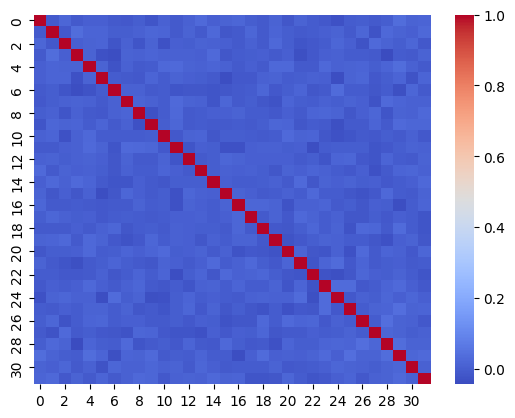

In [ ]:
# correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = np.corrcoef(x_embeddings.detach().cpu().numpy(), rowvar=False)
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.show()

In [ ]:
# output r2 score
from sklearn.metrics import r2_score

model.eval()
with torch.no_grad():
    predictions = model(x_embeddings)
    r2 = r2_score(y_embeddings.numpy(), predictions.numpy())
    print("R2 score:", r2)
    


ValueError: y_true and y_pred have different number of output (1!=32)